In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import shutil
from tqdm import tqdm

import  sys

def mem_size(variable):
    return sys.getsizeof(variable)*1e-6

In [2]:
skin_df = pd.read_csv('C:/Users/RAZER/Downloads/dataset/HAM/HAM10000_metadata.csv')

In [3]:
skin_df["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [4]:
len(skin_df.query("dx == 'nv'")["image_id"].unique())

6705

In [5]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
775

c:\Users\RAZER\anaconda3\envs\Banded_krait\lib\site-packages\ipykernel_launcher.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



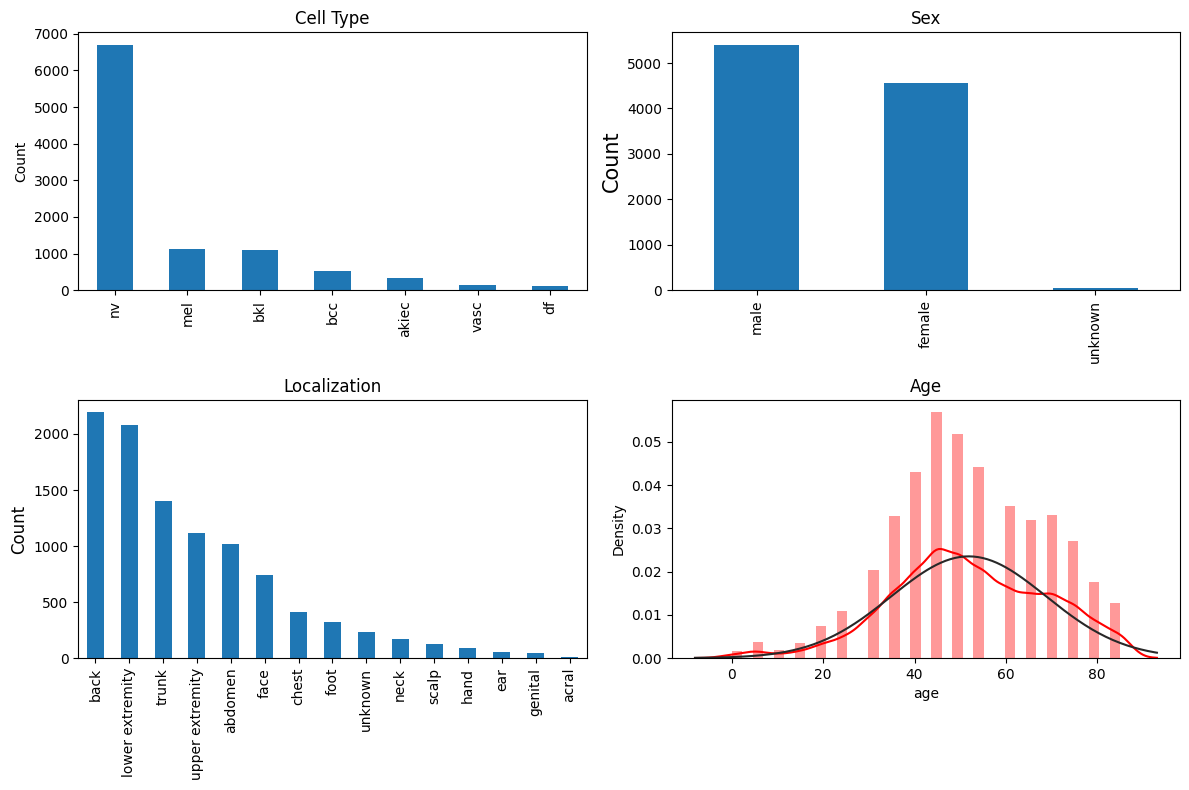

In [6]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [7]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


#Making a Balance

In [8]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [9]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                            df_2_balanced, df_3_balanced, 
                            df_4_balanced, df_5_balanced, df_6_balanced])


In [10]:

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())
skin_df_balanced=skin_df_balanced.reset_index(drop=True)

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [11]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,rosendahl,0
1,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,0
2,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,rosendahl,0
3,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,rosendahl,0
4,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,rosendahl,0
...,...,...,...,...,...,...,...,...,...
3495,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,vidir_modern,6
3496,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,vidir_molemax,6
3497,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,vidir_molemax,6
3498,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,vidir_modern,6


In [12]:
label = skin_df_balanced['dx'].unique().tolist()
label

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [13]:
skin_df_balanced['dx'].value_counts()

akiec    500
bcc      500
bkl      500
df       500
mel      500
nv       500
vasc     500
Name: dx, dtype: int64

In [14]:
len(skin_df_balanced.query("dx == 'vasc'")["image_id"].unique())

137

In [15]:
destination = "C:/Users/RAZER/Downloads/dataset/HAM/Refactored/"
img_path = "C:/Users/RAZER/Downloads/dataset/HAM/all_images/"

In [17]:
try:
    for i in label:
        os.makedirs(destination+i)
except:
    print("file already exists")

file already exists


In [50]:
for i in tqdm(range(skin_df_balanced.shape[0])):
    final_deestination = destination+skin_df_balanced["dx"][i]
    final_source = img_path+skin_df_balanced["image_id"][i]+".jpg"
    shutil.copy(final_source,final_deestination)

100%|██████████| 3500/3500 [00:04<00:00, 812.93it/s] 


In [20]:
img_cls_folder = glob(destination+"*")

In [24]:

for i in dir():
        print(i,"--",'{:f}'.format(mem_size(i))," MB")

BatchNormalization -- 0.000067  MB
Conv2D -- 0.000055  MB
Dense -- 0.000054  MB
Dropout -- 0.000056  MB
Flatten -- 0.000056  MB
Image -- 0.000054  MB
In -- 0.000051  MB
LabelEncoder -- 0.000061  MB
MaxPool2D -- 0.000058  MB
Out -- 0.000052  MB
SIZE -- 0.000053  MB
Sequential -- 0.000059  MB
_ -- 0.000050  MB
_11 -- 0.000052  MB
_12 -- 0.000052  MB
_13 -- 0.000052  MB
_14 -- 0.000052  MB
_18 -- 0.000052  MB
_22 -- 0.000052  MB
_3 -- 0.000051  MB
_4 -- 0.000051  MB
_5 -- 0.000051  MB
__ -- 0.000051  MB
___ -- 0.000052  MB
__builtin__ -- 0.000060  MB
__builtins__ -- 0.000061  MB
__doc__ -- 0.000056  MB
__loader__ -- 0.000059  MB
__name__ -- 0.000057  MB
__package__ -- 0.000060  MB
__spec__ -- 0.000057  MB
__vsc_ipynb_file__ -- 0.000067  MB
_dh -- 0.000052  MB
_i -- 0.000051  MB
_i1 -- 0.000052  MB
_i10 -- 0.000053  MB
_i11 -- 0.000053  MB
_i12 -- 0.000053  MB
_i13 -- 0.000053  MB
_i14 -- 0.000053  MB
_i15 -- 0.000053  MB
_i16 -- 0.000053  MB
_i17 -- 0.000053  MB
_i18 -- 0.000053  MB
_i19 